In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from holotomocupy.proc import linear, dai_yuan
from holotomocupy.tomo import R,RT
from holotomocupy.chunking import gpu_batch
from holotomocupy.utils import *
import holotomocupy.chunking as chunking

%matplotlib inline
chunking.global_chunk = 64 # chunk for GPU processing

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


npos = 1  # number of code positions 

detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 12e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad

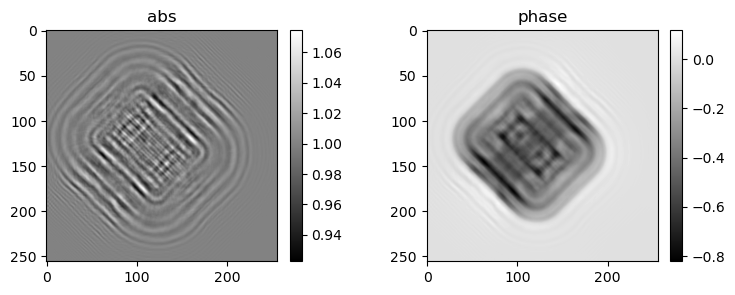

In [3]:
psi_abs = read_tiff('data/rec_abs.tiff')
psi_angle = read_tiff('data/rec_angle.tiff')
psi = psi_abs*np.exp(1j*psi_angle)
mshow_polar(psi[0])

### Computing the logarithm

In [4]:

def _mlog(psi):
    res = psi.copy()
    res[np.abs(psi) < 1e-32] = 1e-32
    res = np.log(res)
    return res

def logtomo(psi):
    """Log representation of projections, -i/\nu log(psi)"""
    return -1j * wavelength / (2*cp.pi) * _mlog(psi) / voxelsize

0) gamma=1, err=4.26340e-03


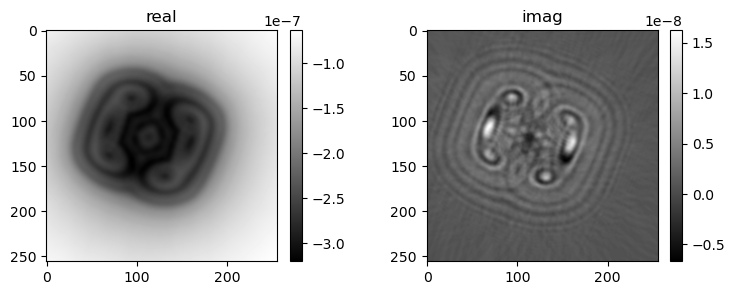

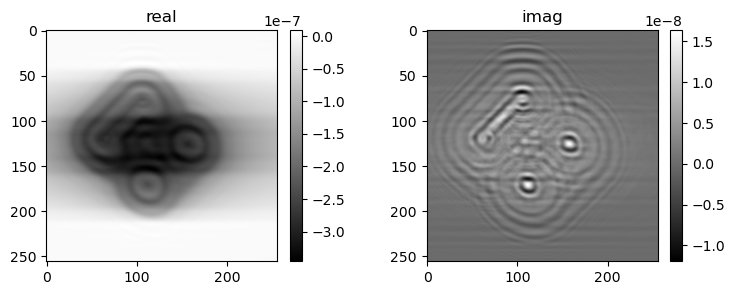

4) gamma=1, err=4.47588e-04
8) gamma=1, err=2.22505e-04
12) gamma=1, err=1.37048e-04
16) gamma=1, err=9.69631e-05


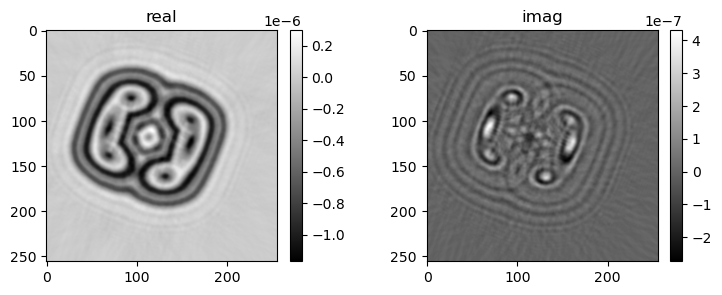

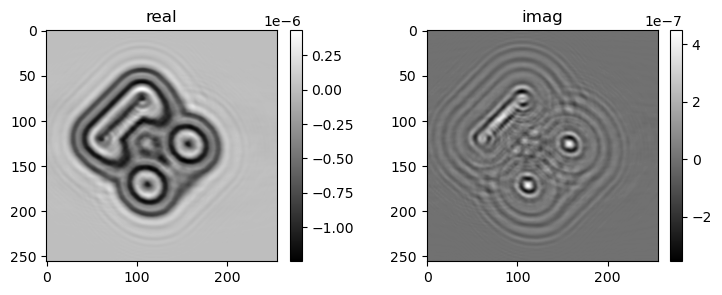

20) gamma=1, err=8.26368e-05
24) gamma=1, err=7.77001e-05
28) gamma=1, err=7.60277e-05
32) gamma=1, err=7.52831e-05


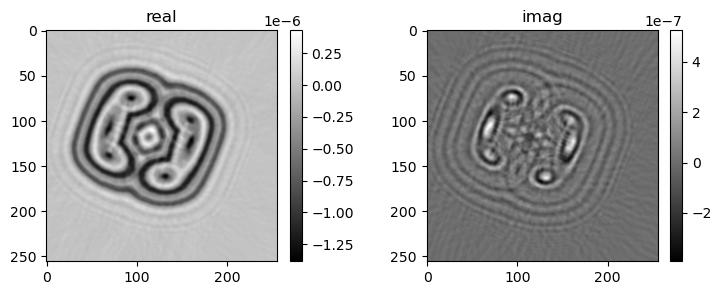

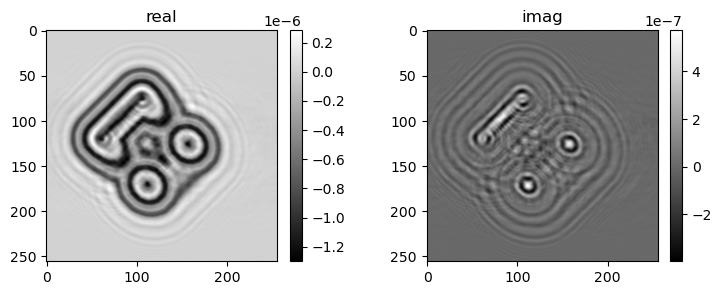

36) gamma=1, err=7.49357e-05
40) gamma=1, err=7.47128e-05
44) gamma=1, err=7.46110e-05
48) gamma=1, err=7.45450e-05


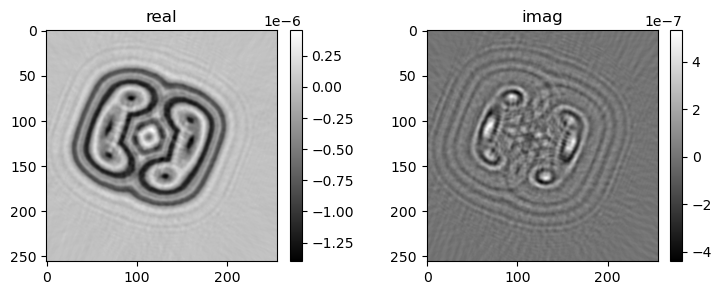

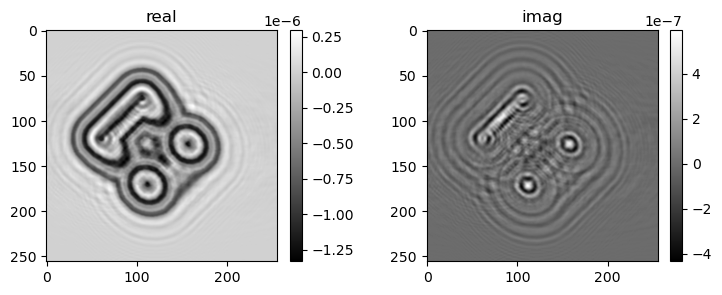

KeyboardInterrupt: 

In [5]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma


def cg_tomo(data, init, pars):
    """Conjugate gradients method for tomogarphy"""
    # minimization functional
    @gpu_batch
    def _minf(Ru, data):
        res = cp.empty(data.shape[0], dtype='float32')
        for k in range(data.shape[0]):
            res[k] = np.linalg.norm(Ru[k]-data[k])**2
        return res

    def minf(Ru):
        res = np.sum(_minf(Ru, data))
        return res

    u = init.copy()
    center_pad = center+ne//4
    for i in range(pars['niter']):
        # Take the gradient
        fu = R(u, theta, center_pad)
        grad = RT(fu-data, theta, center_pad)/np.float32(ne*ntheta)
        # Dai-Yuan direction
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d, grad, grad0)
        grad0 = grad
        fd = R(d, theta, center_pad)
        gamma = line_search(minf, pars['gamma'], fu, fd)
        # update u
        u = linear(u, d, 1, gamma)

        if i % pars['err_step'] == 0:
            fu = R(u, theta, center_pad)
            err = minf(fu)
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_complex(u[u.shape[0]//2, ne//4:-ne//4, ne//4:-ne//4])
            mshow_complex(u[:, ne//2+ne//4+2, ne//4:-ne//4])

    return u

# compute logarithm
data = logtomo(psi)

# if by chunk on gpu
# rec = np.zeros([ne, 3*ne//2, 3*ne//2], dtype='complex64')
# data_rec = np.pad(np.array(data.swapaxes(0, 1)),
#                   ((0, 0), (0, 0), (ne//4, ne//4)), 'edge')

# if fully on gpu
rec = cp.zeros([ne,3*ne//2,3*ne//2],dtype='complex64')
data_rec = cp.pad(cp.array(data.swapaxes(0,1)),((0,0),(0,0),(ne//4,ne//4)),'edge')

pars = {'niter': 129, 'err_step': 4, 'vis_step': 16, 'gamma': 1}
rec = cg_tomo(data_rec, rec, pars)